In [1]:
import torch
import nrrd

In [2]:
from bts.mmformer.mmformer.mmformer import Model

class_num = 4
mmformer = Model(num_cls=class_num)
mmformer_parallel = torch.nn.DataParallel(mmformer).cuda()

weights_path = "/home/desmin/grad_project/bbm47980_bts/bts/mmformer/mmformer/out/model_last.pth"
mmformer_parallel.load_state_dict(torch.load(weights_path)["state_dict"])

<All keys matched successfully>

In [3]:
import numpy as np

fpath = "/home/desmin/data/porcupine_dataset/149/image.nrrd"
img, head = nrrd.read(fpath)

In [4]:
H, W, Z = img.shape
t1ce_channel = 1
patch_size = 128

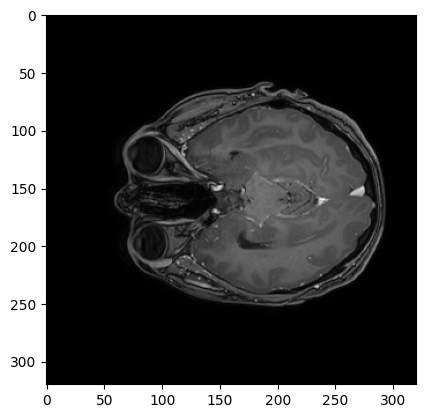

In [5]:
import matplotlib.pyplot as plt

plt.imshow(img[...,80], cmap='gray')

In [6]:
batch = np.zeros((1, 4, H, W, Z), dtype=np.float32)
batch[:,t1ce_channel] = img

batch = torch.from_numpy(batch)

In [7]:
print(batch.shape)

torch.Size([1, 4, 320, 320, 180])


In [8]:
one_tensor = torch.ones(1, patch_size, patch_size, patch_size).float().cuda()

h_cnt = int(np.ceil((H - patch_size) / (patch_size * (1 - 0.5))))
h_idx_list = range(0, h_cnt)
h_idx_list = [h_idx * int(patch_size * (1 - 0.5)) for h_idx in h_idx_list]
h_idx_list.append(H - patch_size)

w_cnt = int(np.ceil((W - patch_size) / (patch_size * (1 - 0.5))))
w_idx_list = range(0, w_cnt)
w_idx_list = [w_idx * int(patch_size * (1 - 0.5)) for w_idx in w_idx_list]
w_idx_list.append(W - patch_size)

z_cnt = int(np.ceil((Z - patch_size) / (patch_size * (1 - 0.5))))
z_idx_list = range(0, z_cnt)
z_idx_list = [z_idx * int(patch_size * (1 - 0.5)) for z_idx in z_idx_list]
z_idx_list.append(Z - patch_size)

#####compute calculation times for each pixel in sliding windows
weight1 = torch.zeros(1, 1, H, W, Z).float().cuda()
for h in h_idx_list:
    for w in w_idx_list:
        for z in z_idx_list:
            weight1[:, :, h:h+patch_size, w:w+patch_size, z:z+patch_size] += one_tensor
weight = weight1.repeat(1, class_num, 1, 1, 1)

In [9]:
feature_mask = [False, True, False, False] # only include T1 CONTRAST
mask = torch.from_numpy(np.array(feature_mask))
mask = torch.unsqueeze(mask, dim=0).repeat(1, 1)

In [11]:
mmformer_parallel.eval()

patch_size = 128
with torch.no_grad():
    batch = batch.cuda()
    mask = mask.cuda()
    print(mask)
    pred = torch.zeros(1, class_num, H, W, Z).float().cuda()
    mmformer_parallel.module.is_training=False
    for h in h_idx_list:
        for w in w_idx_list:
            for z in z_idx_list:
                batch_i = batch[:, :, h:h+patch_size, w:w+patch_size, z:z+patch_size]
                print(batch_i.shape)
                pred_part = mmformer_parallel(batch_i, mask)
                pred[:, :, h:h+patch_size, w:w+patch_size, z:z+patch_size] += pred_part
    pred = pred / weight
    pred = pred[:, :, :H, :W, :Z]
    pred = torch.argmax(pred, dim=1)

tensor([[False,  True, False, False]], device='cuda:0')
torch.Size([1, 4, 128, 128, 128])
torch.Size([1, 4, 8, 128, 128, 128])
torch.Size([1, 4, 16, 64, 64, 64])
torch.Size([1, 4, 32, 32, 32, 32])
torch.Size([1, 4, 64, 16, 16, 16])
torch.Size([1, 4, 512, 8, 8, 8])
torch.Size([1, 4, 128, 128, 128])
torch.Size([1, 4, 8, 128, 128, 128])
torch.Size([1, 4, 16, 64, 64, 64])
torch.Size([1, 4, 32, 32, 32, 32])
torch.Size([1, 4, 64, 16, 16, 16])
torch.Size([1, 4, 512, 8, 8, 8])
torch.Size([1, 4, 128, 128, 128])
torch.Size([1, 4, 8, 128, 128, 128])
torch.Size([1, 4, 16, 64, 64, 64])
torch.Size([1, 4, 32, 32, 32, 32])
torch.Size([1, 4, 64, 16, 16, 16])
torch.Size([1, 4, 512, 8, 8, 8])
torch.Size([1, 4, 128, 128, 128])
torch.Size([1, 4, 8, 128, 128, 128])
torch.Size([1, 4, 16, 64, 64, 64])
torch.Size([1, 4, 32, 32, 32, 32])
torch.Size([1, 4, 64, 16, 16, 16])
torch.Size([1, 4, 512, 8, 8, 8])
torch.Size([1, 4, 128, 128, 128])
torch.Size([1, 4, 8, 128, 128, 128])
torch.Size([1, 4, 16, 64, 64, 64])
to

In [10]:
pred = pred.cpu().numpy()[0]

In [15]:
pred.shape, img.shape

((232, 256, 176), (232, 256, 176))

In [16]:
np.unique(pred)

array([0, 1, 2, 3])

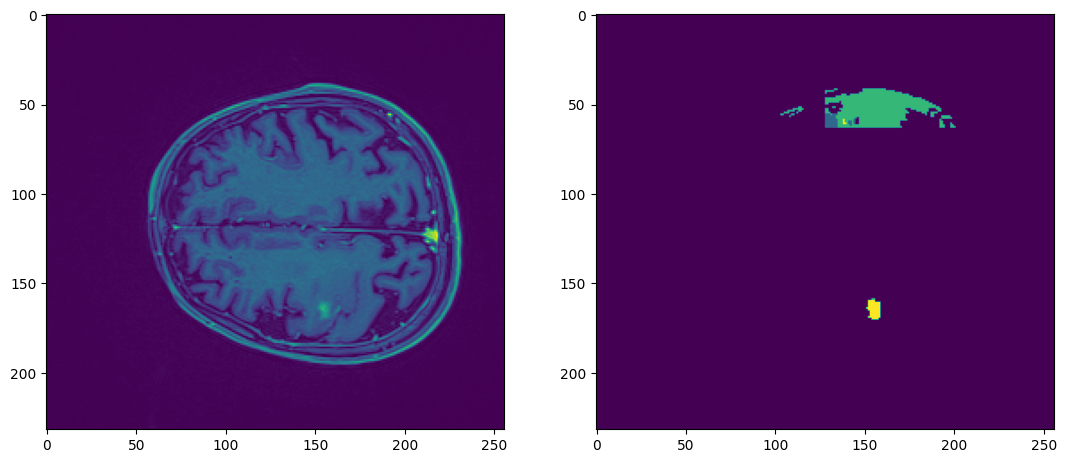

In [21]:
fig, axs = plt.subplots(1,2,figsize=(13,6))

axs[0].imshow(img[...,130])
axs[1].imshow(pred[...,130])

plt.show()

In [22]:
nrrd.write("/home/desmin/data/mmformer_infers/0_label.nrrd",pred)
nrrd.write("/home/desmin/data/mmformer_infers/0_img.nrrd", img)

In [40]:
def test_model(
    im_path : str,
    label_path : str
):
    img, _ = nrrd.read(im_path)
    label = np.load(label_path)
    
    H, W, Z = img.shape
    t1ce_channel = 1
    patch_size = 128
    
    batch = np.zeros((1, 4, H, W, Z), dtype=np.float32)
    batch[:,t1ce_channel] = img

    batch = torch.from_numpy(batch)
    

    
    one_tensor = torch.ones(1, patch_size, patch_size, patch_size).float().cuda()

    h_cnt = int(np.ceil((H - patch_size) / (patch_size * (1 - 0.5))))
    h_idx_list = range(0, h_cnt)
    h_idx_list = [h_idx * int(patch_size * (1 - 0.5)) for h_idx in h_idx_list]
    h_idx_list.append(H - patch_size)

    w_cnt = int(np.ceil((W - patch_size) / (patch_size * (1 - 0.5))))
    w_idx_list = range(0, w_cnt)
    w_idx_list = [w_idx * int(patch_size * (1 - 0.5)) for w_idx in w_idx_list]
    w_idx_list.append(W - patch_size)

    z_cnt = int(np.ceil((Z - patch_size) / (patch_size * (1 - 0.5))))
    z_idx_list = range(0, z_cnt)
    z_idx_list = [z_idx * int(patch_size * (1 - 0.5)) for z_idx in z_idx_list]
    z_idx_list.append(Z - patch_size)

    #####compute calculation times for each pixel in sliding windows
    weight1 = torch.zeros(1, 1, H, W, Z).float().cuda()
    for h in h_idx_list:
        for w in w_idx_list:
            for z in z_idx_list:
                weight1[:, :, h:h+patch_size, w:w+patch_size, z:z+patch_size] += one_tensor
    weight = weight1.repeat(1, class_num, 1, 1, 1)
    
    feature_mask = [False, True, False, False] # only include T2
    mask = torch.from_numpy(np.array(feature_mask))
    mask = torch.unsqueeze(mask, dim=0).repeat(1, 1)
    
    with torch.no_grad():
        batch = batch.cuda()
        mask = mask.cuda()

        pred = torch.zeros(1, class_num, H, W, Z).float().cuda()
        mmformer_parallel.module.is_training=False
        for h in h_idx_list:
            for w in w_idx_list:
                for z in z_idx_list:
                    batch_i = batch[:, :, h:h+patch_size, w:w+patch_size, z:z+patch_size]
                    pred_part = mmformer_parallel(batch_i, mask)
                    pred[:, :, h:h+patch_size, w:w+patch_size, z:z+patch_size] += pred_part
        pred = pred / weight
        pred = pred[:, :, :H, :W, :Z]
        pred = torch.argmax(pred, dim=1)
        
    return img, pred[0].cpu().numpy(), label

In [67]:
img, pred, label = test_model(
    "/home/desmin/data/porcupine_dataset/83/image.nrrd",
    "/home/desmin/data/porcupine_dataset/83/transform_label.npy"
)

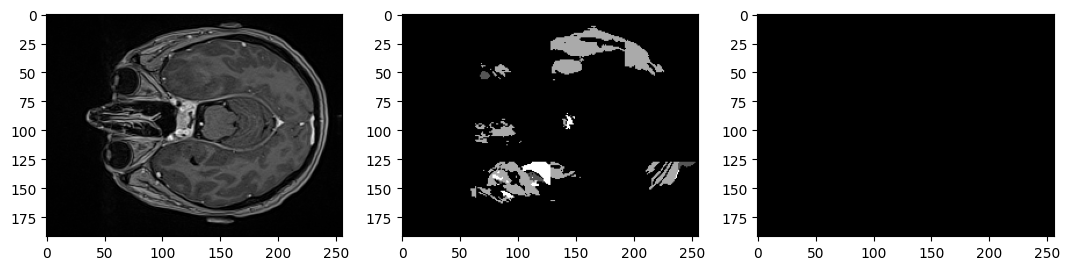

In [72]:
fig, axs = plt.subplots(1,3,figsize=(13,6))

slice_index = 70

axs[0].imshow(img[...,slice_index], cmap='gray')
axs[1].imshow(pred[...,slice_index], cmap='gray')
axs[2].imshow(label[...,slice_index]==1, cmap='gray')

plt.show()